In [2]:
import warnings; warnings.filterwarnings("ignore")
import numpy as np; import scipy as sp; import pandas as pd
import matplotlib.pyplot as plt
import mne; mne.utils.set_log_level('error')
from functools import reduce
from time import time
import local
from models.preprocessing import utils
from pickle import load

In [3]:
d="G:/Julia/New_Datasets/RawData_new/"
ext="-bytrial.pac.json"
box=utils.select_dataset(d,ext);box

In [4]:
def get_trial_pos_in_block(block_type,block_index,df):
    pos = np.zeros_like(df.BlockIndex)*0.
    mask = np.logical_and(df.BlockType==block_type,df.BlockIndex==block_index)
    pos[mask] = (np.arange(np.sum(mask))+1)/np.sum(mask)
    return pos
def get_masked(subject,funs=[lambda x: np.logical_and(x.StimulusType<200,x.FeedbackType=='negative'), lambda x: np.logical_and(x.StimulusType<200,x.FeedbackType=='positive')]):
    file = open(d+subject+ext,"rb")
    dct = load(file)
    df = pd.read_csv(d[:-4]+"Epochs/"+subject+"-epo.csv")
    #df['BlockPosition']=np.sum([get_trial_pos_in_block(a,b,df) for a,b in zip(['visual/right','visual/right','visual/left','visual/left','auditive/right','auditive/right','auditive/left','auditive/left'],[1,2,1,2,1,2,1,2])],axis=0)
    ch = sorted(set(dct.keys()))
    fp = sorted(set([k[0] for k in dct['Fz'].keys()]))
    fa = sorted(set([k[1] for k in dct['Fz'].keys()]))
    dat = np.array([[[dct[c][(p,a)][0] for p in fp] for a in fa] for c in ch]).T
    return [dat[fn(df),:,:,:] for fn in funs]
def plot_masked_tfr(T,m,ax,labels={},kwargs={}):
    ax.imshow(np.repeat(T,1,-1),origin='lower',cmap='Greys')
    sig_T = np.copy(T)
    sig_T[np.logical_not(m)]=np.nan
    im = ax.imshow(np.repeat(sig_T,1,-1),origin='lower',cmap='Spectral_r',**kwargs);
    if 'x' in labels.keys():
        xticks,xlabels = labels.get('x')
        ax.set_xticks(xticks)
        ax.set_xticklabels(xlabels)
    if 'y' in labels.keys():
        yticks,ylabels = labels.get('y')
        ax.set_yticks(yticks)
        ax.set_yticklabels(ylabels)
    return im
def plot_famp_topos(a,b,alpha=.05):
    T,c,p,_ = mne.stats.permutation_cluster_test([np.mean(cor_data[:,:,a:b,:],axis=2),np.mean(inc_data[:,:,a:b,:],axis=2)],connectivity=None)
    sig_cls = np.array([d for d,q in zip(c,p) if q<alpha])
    fig,axs = plt.subplots(2,3,figsize=(15,10))
    axs = [a for ax in axs for a in ax]
    for i,ax in enumerate(axs):
        mne.viz.plot_topomap(T[i,:],info,mask=np.any(sig_cls[:,i,:],axis=0),cmap='Spectral_r',axes=ax,show=False);
        ax.set_title("Phase Freq {}-{}Hz".format(fp[i][0],fp[i][1]))
    fig.suptitle("PAC with {}-{}Hz frequency band".format(fa[a][0],fa[b-1][1]))
    return fig

In [6]:
subjects = [subject for subject in utils.get_selection(box) if 'stimulus' in subject]
file = open(d+subjects[0]+ext,"rb")
dct = load(file)
ch = sorted(set(dct.keys()))
fp = sorted(set([k[0] for k in dct[ch[0]].keys()]))
fa = sorted(set([k[1] for k in dct[ch[0]].keys()]))

In [6]:
data = [get_masked(subject) for subject in utils.get_selection(box) if 'stimulus' in subject and not 'Test' in subject]
mean_data = np.mean(np.vstack([list(z) for z in zip(*data)][1]),axis=0)-np.mean(np.vstack([list(z) for z in zip(*data)][0]),axis=0)

T,c,p,_ = mne.stats.permutation_cluster_test([np.vstack([list(z) for z in zip(*data)][0]),np.vstack([list(z) for z in zip(*data)][1])],connectivity=None)

sig_cls = [d for d,q in zip(c,p) if q<.05]
sig_ch = np.array(sorted(ch))[np.sum(sig_cls[0],axis=(0,1))>0]

### PAC for significant channels, T-values for correct vs incorrect responses

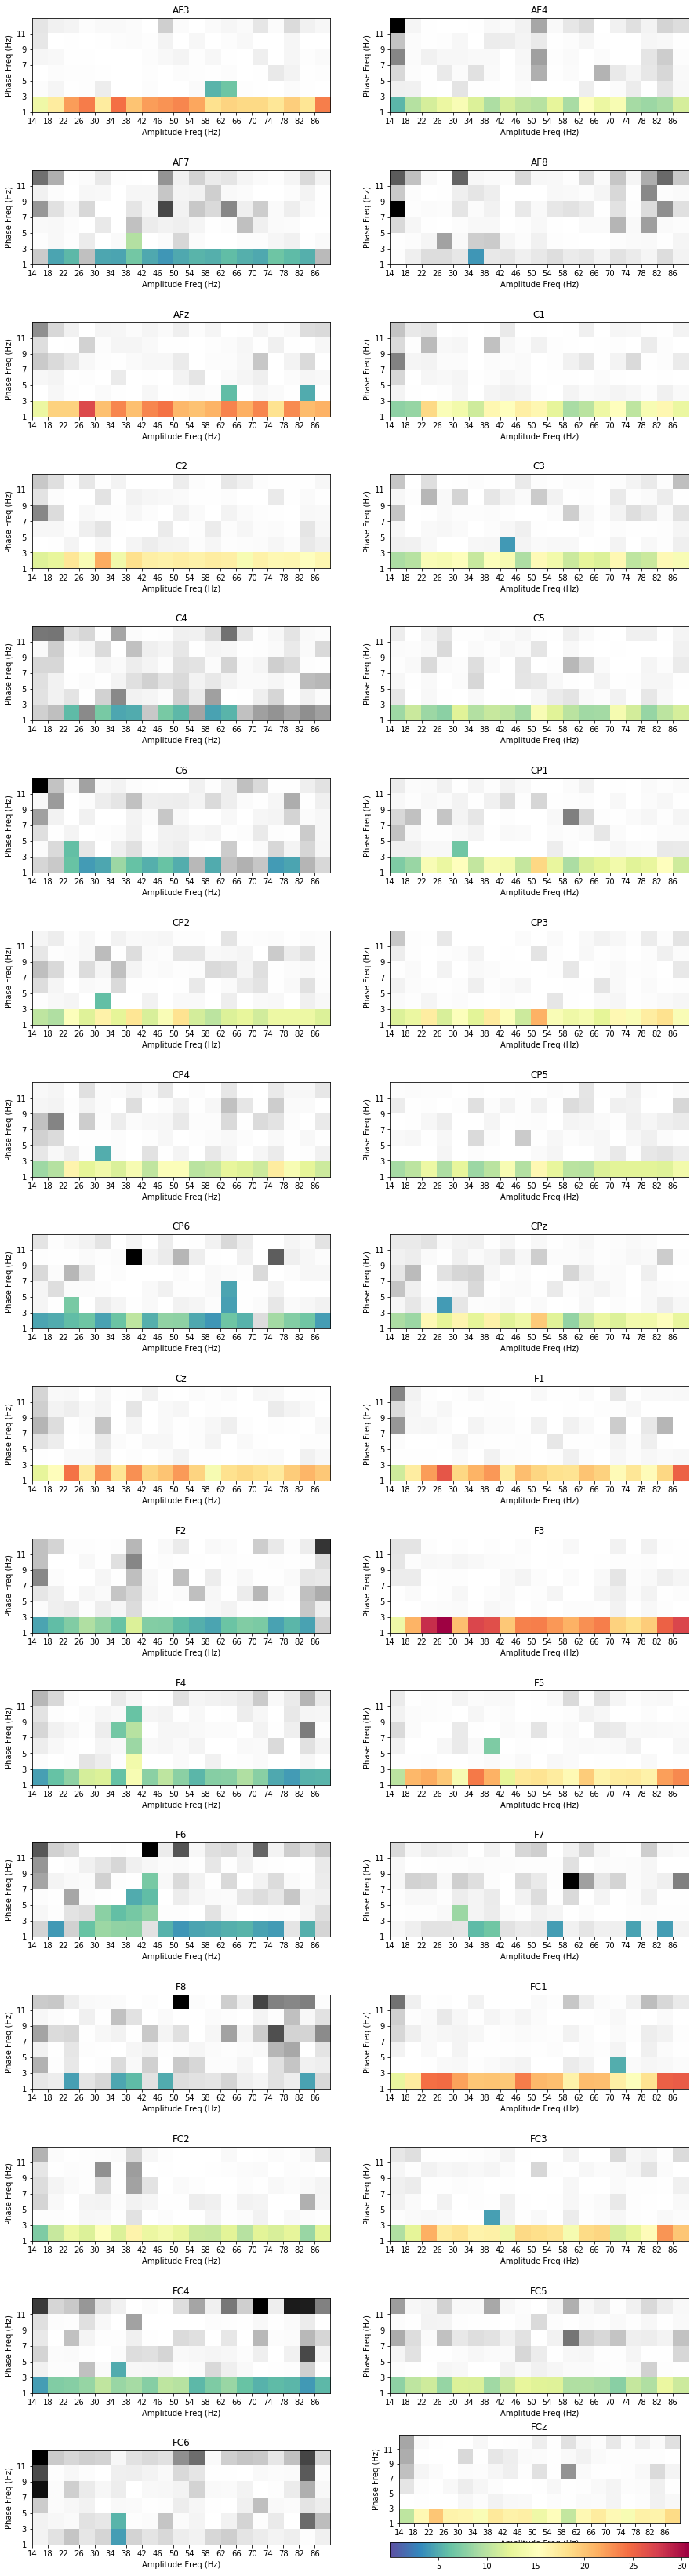

In [9]:
fig,axs = plt.subplots(-(-len(sig_ch)//2),2,figsize=(15,60))
axs = [a for ax in axs for a in ax]
vmin=np.min(T);vmax=np.max(T)
for i,a in enumerate(axs):    
    chidx = np.where(np.array(sorted(ch))==sig_ch[i])[0][0]
    im = plot_masked_tfr(T[:,:,chidx],np.any(sig_cls,axis=0)[:,:,chidx],a,labels={'x':(np.arange(len(fa))-.5,[f[0] for f in sorted(fa)]),'y':(np.arange(len(fp))-.5,[f[0] for f in sorted(fp)])},kwargs={'vmin':vmin,'vmax':vmax})
    a.set_ylabel("Phase Freq (Hz)")
    a.set_xlabel("Amplitude Freq (Hz)")
    a.set_title(sig_ch[i])
#fig.suptitle("PAC for significant channels, T-values");
fig.colorbar(im,orientation='horizontal');

### PAC for significant channels, difference between mean values for correct vs incorrect responses

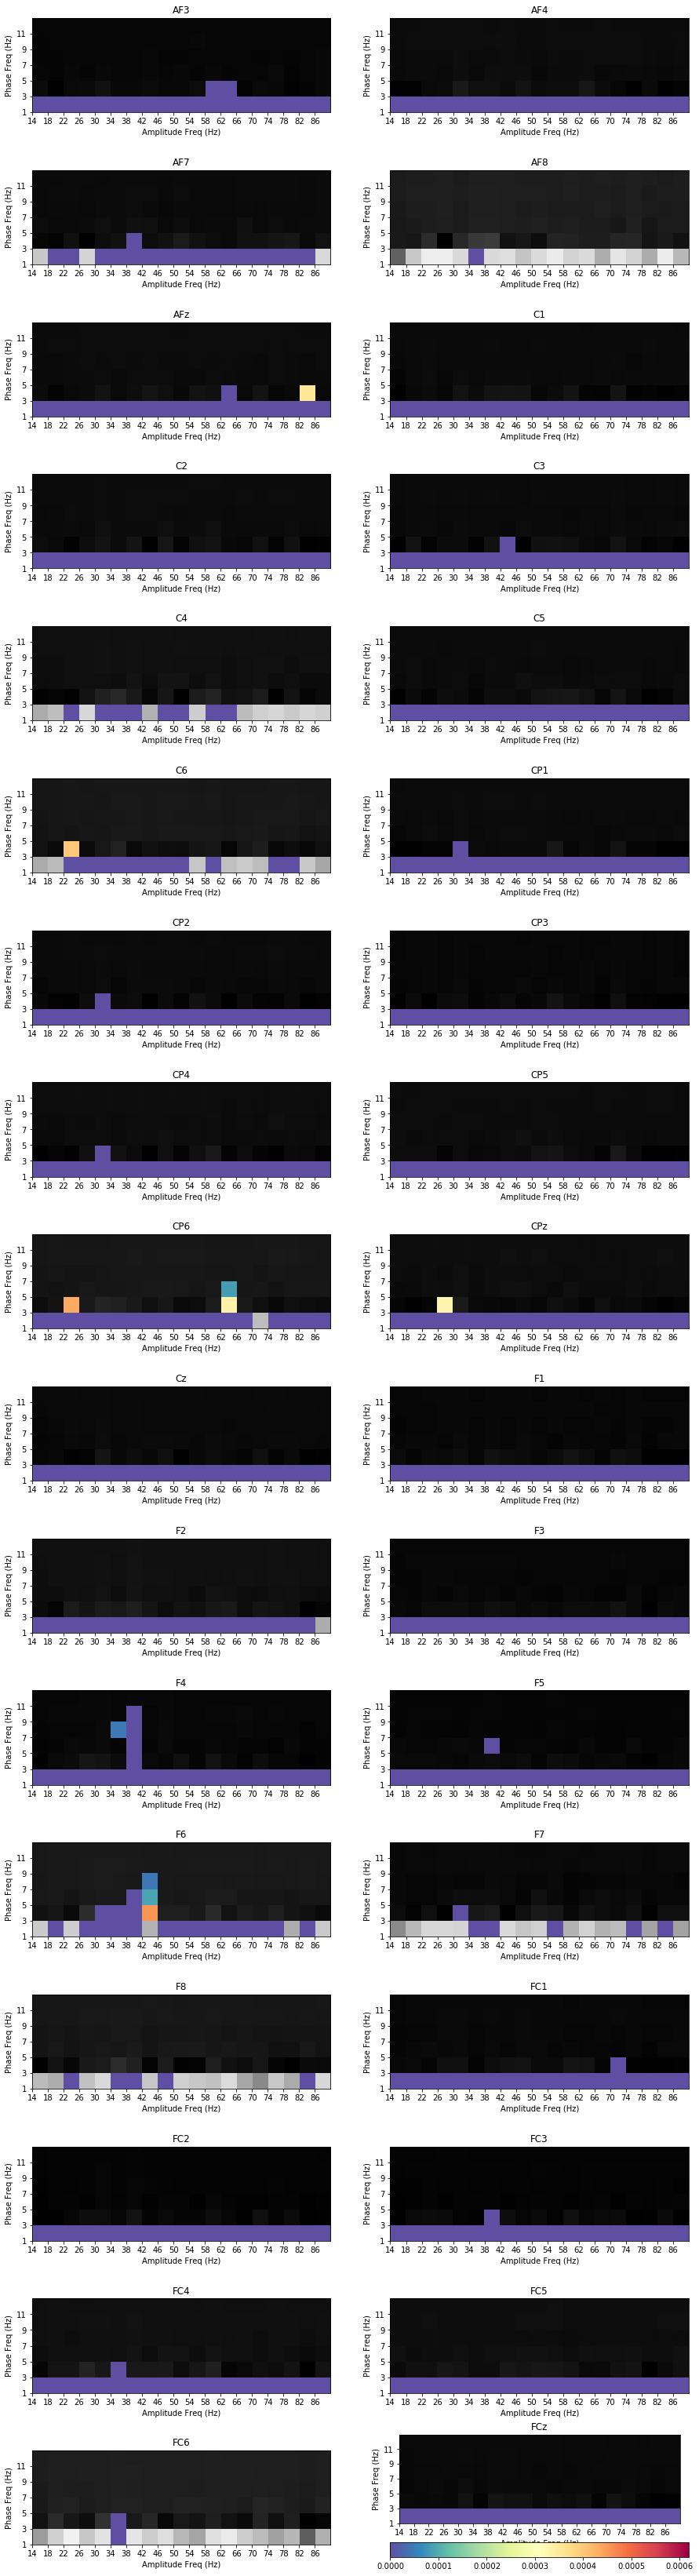

In [15]:
fig,axs = plt.subplots(-(-len(sig_ch)//2),2,figsize=(15,60))
axs = [a for ax in axs for a in ax]
#corr_data = np.mean(np.vstack([list(z) for z in zip(*data)][1]),axis=0)
vmax=np.max(mean_data);vmin=0#np.min(corr_data);
for i,a in enumerate(axs):    
    chidx = np.where(np.array(sorted(ch))==sig_ch[i])[0][0]
    im = plot_masked_tfr(mean_data[:,:,chidx],np.any(sig_cls,axis=0)[:,:,chidx],a,labels={'x':(np.arange(len(fa))-.5,[f[0] for f in sorted(fa)]),'y':(np.arange(len(fp))-.5,[f[0] for f in sorted(fp)])},kwargs={'vmin':vmin,'vmax':vmax})
    a.set_ylabel("Phase Freq (Hz)")
    a.set_xlabel("Amplitude Freq (Hz)")
    a.set_title(sig_ch[i])
fig.colorbar(im,orientation='horizontal');

In [ ]:
cor_data,inc_data = (np.vstack([list(z) for z in zip(*data)][1]),np.vstack([list(z) for z in zip(*data)][0]))
info = mne.io.read_info(d[:-4]+"Epochs/"+subjects[0]+"-epo.fif.gz")

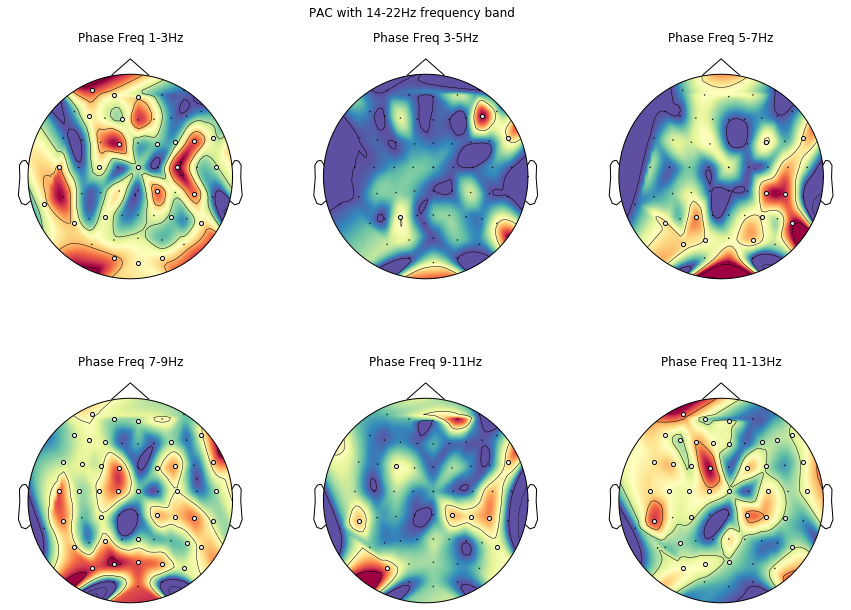

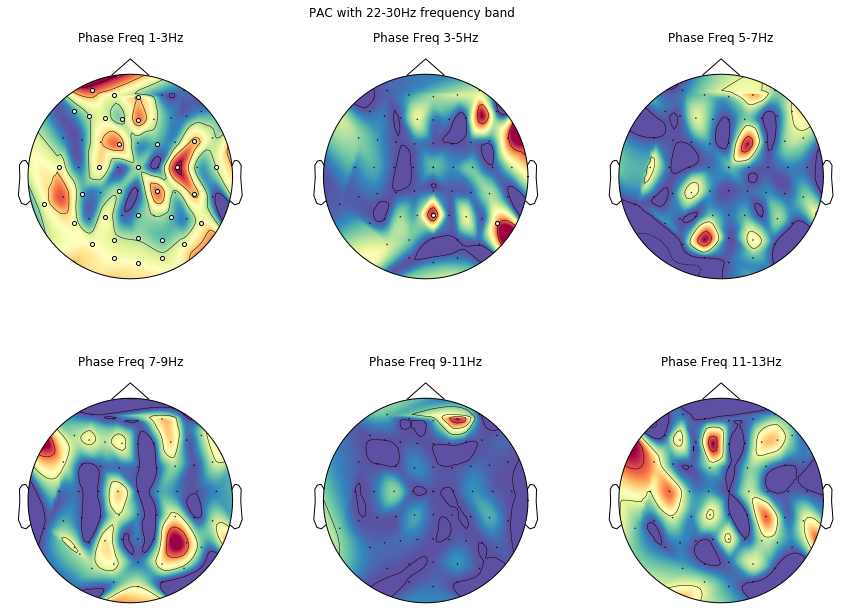

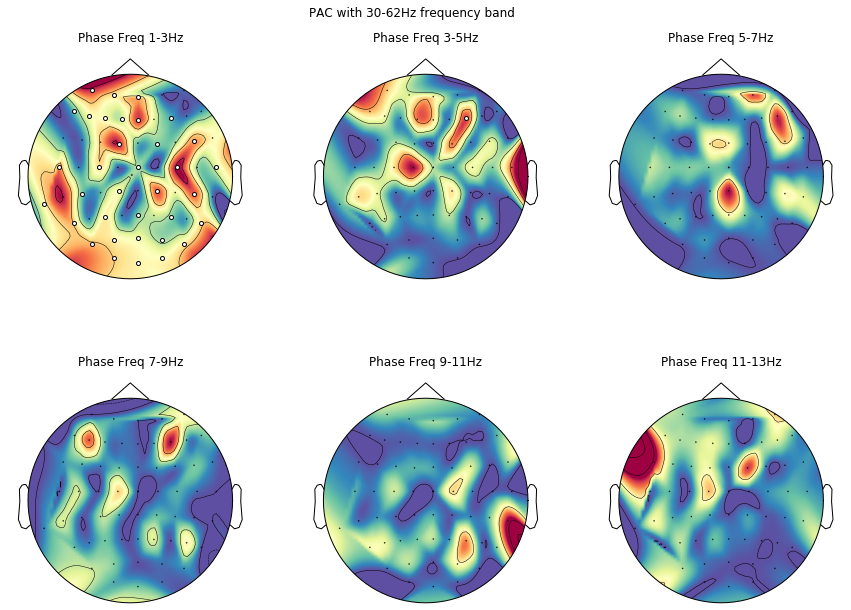

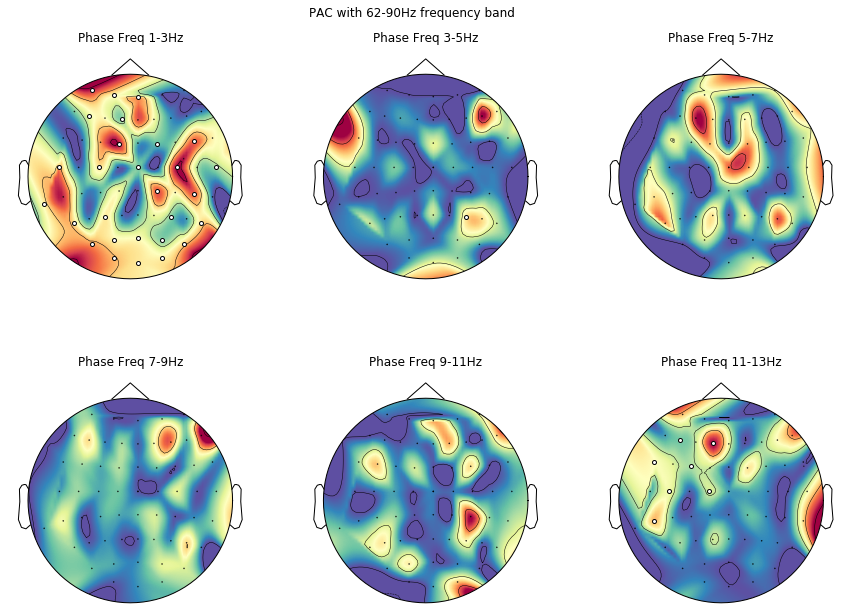

In [22]:
[plot_famp_topos(a,b) for a,b in [(0,2),(2,4),(4,12),(12,19)]];

#### Snippets:

In [94]:
info = mne.io.read_info(d[:-4]+"Epochs/"+"multiModal_eeg_081CG.feedback"+"-epo.fif.gz")
conn = mne.channels.find_ch_connectivity(info,'eeg')